In [1]:
%matplotlib widget
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def imshow(frame, dpi=160):
  im_data = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
  height, width, depth = im_data.shape

  # What size does the figure need to be in inches to fit the image?
  figsize = width / float(dpi), height / float(dpi)

  # Create a figure of the right size with one axes that takes up the full figure
  fig = plt.figure(figsize=figsize)
  ax = fig.add_axes([0, 0, 1, 1])

  # Hide spines, ticks, etc.
  ax.axis('off')

  # Display the image.
  ax.imshow(im_data, cmap='gray')

  plt.show()

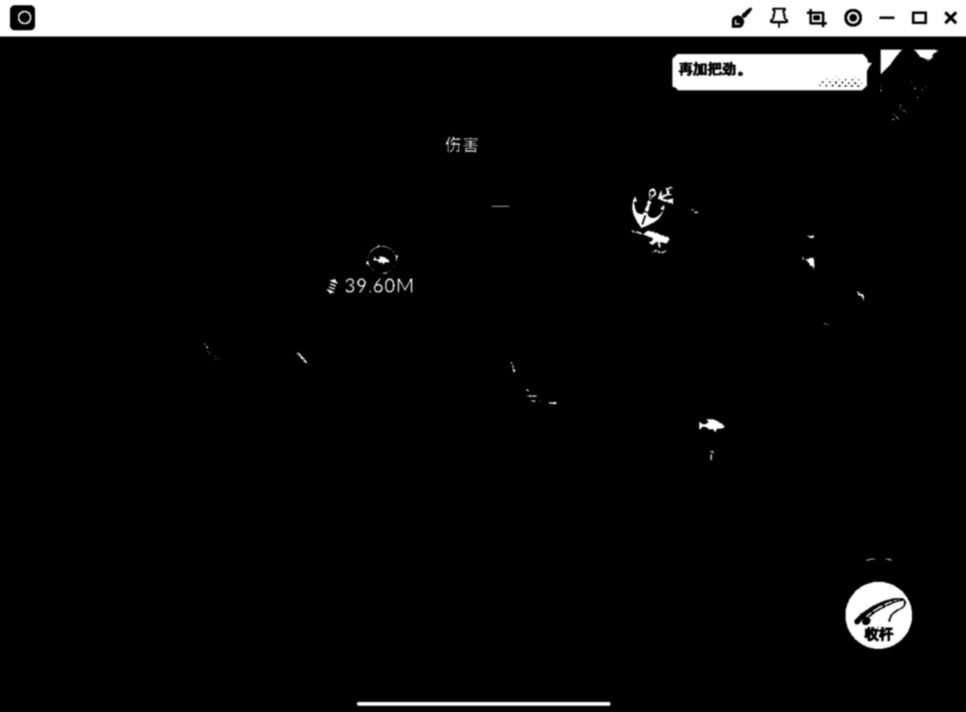

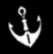

In [3]:
image = cv.imread('data/labeled/fish_drag/2022-08-11T09:41:25.067998.png')
anchor_image = cv.imread('data/templates/anchor.png')
# image = cv.cvtColor(image, cv.COLOR_BGR2HSV)
dst = cv.inRange(image, (240, 240, 240), (255, 255, 255))
dst = cv.GaussianBlur(dst, (5, 5), 0)
anchor_dst = cv.inRange(anchor_image, (240, 240, 240), (255, 255, 255))
anchor_dst = cv.GaussianBlur(anchor_dst, (5, 5), 0)
imshow(dst)
imshow(anchor_dst)

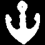

In [4]:
contours, _ = cv.findContours(anchor_dst, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
contours = cv.convexHull(np.vstack(contours))

# cv.drawContours(anchor_image, [contours], -1, (0, 255, 0))
# imshow(anchor_image)
# minRect = cv.minAreaRect(np.vstack(contours))
# box = cv.boxPoints(minRect)
# box = np.intp(box)

# peri = cv.arcLength(contours, True)
# approx = cv.approxPolyDP(contours, 0.02 * peri, True)
# cv.drawContours(anchor_image, [approx], 0, (0, 255, 0))

ellipse = cv.fitEllipse(contours)
# cv.ellipse(anchor_image,ellipse,(0,255,0),2)
center, size, angle = ellipse
rot_mat = cv.getRotationMatrix2D(center, angle + 180, scale=1)
rotated_image = cv.warpAffine(anchor_dst, rot_mat, np.intp(center + np.max(size)))
_, rotated_image = cv.threshold(rotated_image, 5, 255, cv.THRESH_BINARY)
contours = cv.transform(contours, rot_mat)
# we need a square for rotation later
x, y, w, h = cv.boundingRect(contours)
d = np.ceil(max(w, h) / 2) * 2
x = x + w / 2 - d / 2
y = y + h / 2 - d / 2
anchor_mask = rotated_image[int(y):int(y+d),int(x):int(x+d)]
imshow(anchor_mask)

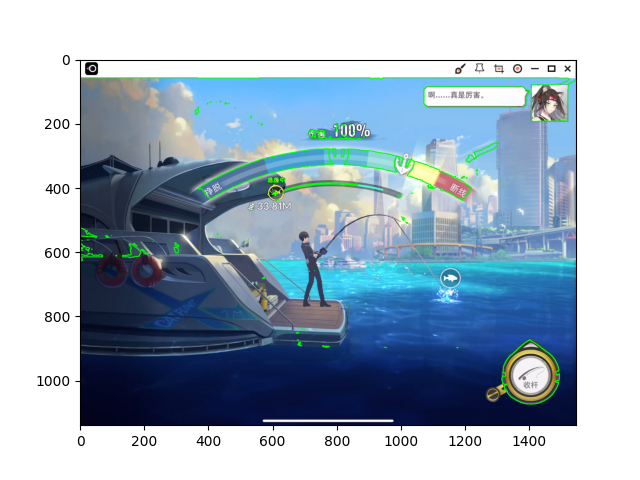

In [5]:
%matplotlib widget
img1 = cv.imread('data/labeled/fish_drag/2022-08-11T09:41:22.906871.png')
img2 = cv.imread('data/labeled/fish_drag/2022-08-11T09:47:22.305511.png')
img_diff = cv.absdiff(img1, img2)
mask = np.max(img_diff, 2)
# mask = cv.cvtColor(img_diff, cv.COLOR_BGR2GRAY)
mask = cv.GaussianBlur(mask, (5, 5), 0)
_, mask = cv.threshold(mask, 15, 255, cv.THRESH_BINARY_INV)
contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=lambda c: cv.contourArea(c), reverse=True)
cv.drawContours(img1, contours, -1, (0, 255, 0), 2)

fig = plt.figure()
im_data = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
plt.imshow(im_data)
included_contours = []
points = []

## Click the contours on the gauge.
def onclick(event):
  x, y = event.xdata, event.ydata
  points.append((x, y))
  for c in contours:
    if cv.pointPolygonTest(c, (x, y), False) >= 0:
      included_contours.append(c)
  if included_contours:
    hull = cv.convexHull(np.vstack(included_contours))
    plt.imshow(cv.drawContours(im_data.copy(), [hull], 0, (0, 0, 255), 2))
    plt.draw()
ka = fig.canvas.mpl_connect('button_press_event', onclick)
# imshow(img1)

In [8]:
def get_intersect(a1, a2, b1, b2):
  s = np.vstack([a1,a2,b1,b2])        # s for stacked
  h = np.hstack((s, np.ones((4, 1)))) # h for homogeneous
  l1 = np.cross(h[0], h[1])           # get first line
  l2 = np.cross(h[2], h[3])           # get second line
  x, y, z = np.cross(l1, l2)          # point of intersection
  if z == 0:                          # lines are parallel
    return None
  return (x/z, y/z)

[368 403] [775 279] [1221  402]
[571.5 341. ] [447.5 -66. ] [998.  340.5] [1121.  -105.5]
center= [ 795 1075] radius= 796.2512166395728 radius2= 749.7168703739069 diff= 46.53434626566593


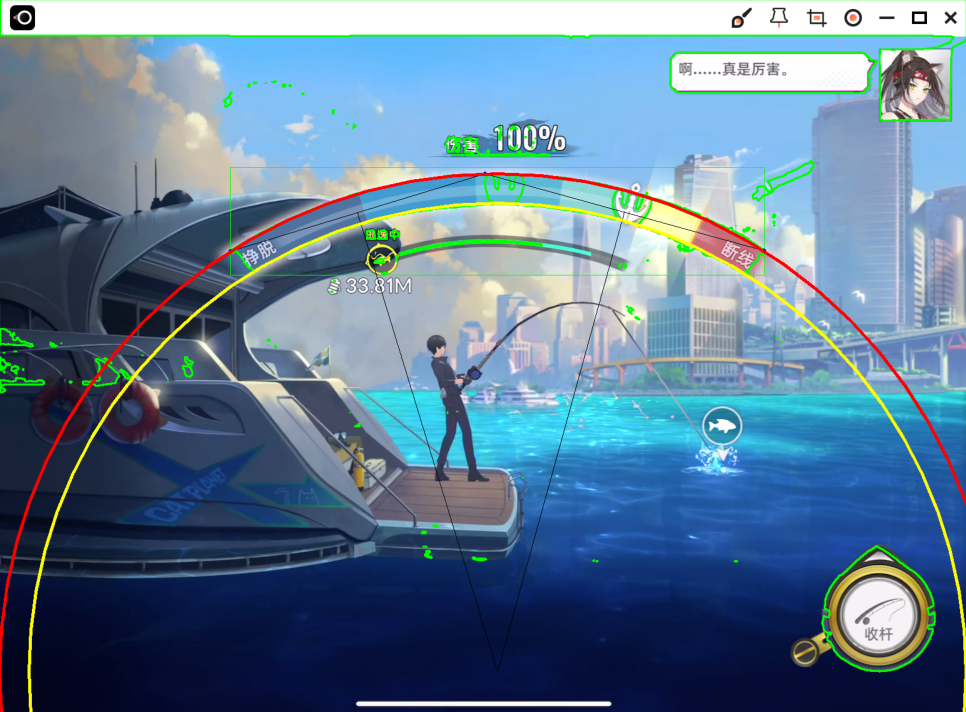

In [9]:
img = img1.copy()

hull = cv.convexHull(np.vstack(included_contours))
bounding_rect = np.array(cv.boundingRect(np.vstack(included_contours)))
# add 10 pixel for anchor tail
bounding_rect[1] -= 10  # y
bounding_rect[3] += 10  # h
cv.rectangle(img, bounding_rect[:2], bounding_rect[:2] + bounding_rect[2:], (0, 255, 0))

# top = hull[np.argmin(hull[:,:,1]),0]
left = hull[np.argmin(hull[:,:,0]),0]
right = hull[np.argmax(hull[:,:,0]),0]
mid = (left[0] + right[0]) / 2
top = hull[np.argmin(np.abs(hull[:,:,0] - mid)),0]
print(left, top, right)
a1 = (top + left) / 2
a2 = a1 + np.flip(top - left) * (1, -1)
b1 = (top + right) / 2
b2 = b1 + np.flip(right - top) * (1, -1)
print(a1, a2, b1, b2)
center = np.intp(get_intersect(a1, a2, b1, b2))

cv.circle(img, left, 2, (255, 0, 0), 2)
cv.circle(img, top, 2, (255, 0, 0), 2)
cv.circle(img, right, 2, (255, 0, 0), 2)
cv.line(img, top, left, 0)
cv.line(img, top, right, 0)
cv.line(img, np.intp(a1), center, 0)
cv.line(img, np.intp(b1), center, 0)
radius = cv.norm(top-center)
cv.circle(img, center, np.intp(radius), (0, 0, 255), 3)

distances = []
for point in np.vstack(included_contours)[:,0,:]:
  d = cv.norm(point - center)
  if radius - d < 5:
    continue
  distances.append(d)
radius2 = np.average(sorted(distances)[:int(len(distances) * 0.9)])
cv.circle(img, center, np.intp(radius2), (0, 255, 255), 3)
print('center=', center, 'radius=', radius, 'radius2=', radius2, 'diff=', radius - radius2)

imshow(img, dpi=160)

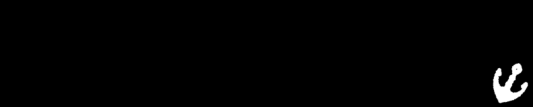

In [10]:
import itertools

# relevant to x.
left_deg = np.arccos((left[0] - center[0]) / radius) * 180 / np.pi
right_deg = np.arccos((right[0] - center[0]) / radius) * 180 / np.pi

contour_box = np.array([[0, 0], [1, 0], [1, 1], [0, 1]])

def rotated_anchor_mask(angle):
  # create mask to bounding_rect
  x, y, w, h = bounding_rect
  mask = np.zeros((h, w), np.uint8)
  mask_center = np.array(center) - np.array((x, y))
  # rotate anchor
  anchor_radius = int(anchor_mask.shape[0]/2)
  rot_mat = cv.getRotationMatrix2D((anchor_radius, anchor_radius), angle - 90, 1)
  rotated_anchor_mask = cv.warpAffine(anchor_mask.copy(), rot_mat,
                                      [anchor_radius * 2, anchor_radius * 2])
  # place anchor
  rad = angle / 180 * np.pi
  anchor_center_radius = radius2 + 26  # = (72 - 5 blur - 15 tail) / 2
  vector = np.array((np.cos(rad), -np.sin(rad))) * anchor_center_radius
  anchor_center = np.int32(mask_center + vector)
  anchor_top_left = anchor_center - anchor_radius
  # calc intersect
  ret, intersect = cv.intersectConvexConvex(
      np.int32(np.array([0, 0]) + contour_box * [w, h]),
      np.int32(anchor_top_left + contour_box * anchor_radius * 2))
  if not ret:
    return mask
  intersect = intersect.reshape(4, 2)

  top_left = np.int32(intersect[np.argmin(intersect.sum(1))])
  bottom_right = np.int32(intersect[np.argmax(intersect.sum(1))])
  # print(top_left, bottom_right, mask[top_left[1]:bottom_right[1],
  #                                    top_left[0]:bottom_right[0]].shape)
  indices = np.indices(rotated_anchor_mask.shape).swapaxes(0, 2).swapaxes(0, 1)
  indices = np.logical_and(
      np.all((top_left - anchor_top_left)[::-1] <= indices, 2),
      np.all(indices < (bottom_right - anchor_top_left)[::-1], 2))
  cv.copyTo(
      rotated_anchor_mask[indices].reshape((bottom_right - top_left)[::-1]),
      None, mask[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]])
  return mask
imshow(rotated_anchor_mask(60))

68.667189701825 811


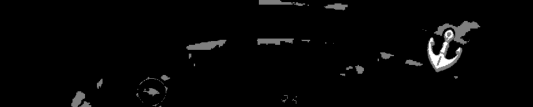

In [15]:
test_image = cv.imread('data/raw/2022-08-13T12:07:45.005877.png')
x, y, w, h = bounding_rect
test_image = test_image[y:y+h,x:x+w]
test_image = cv.inRange(test_image, (240, 240, 240), (255, 255, 255))

max_angle = left_deg
max_score = 0
angle = left_deg
d_deg = abs(left_deg - right_deg) / 100
while angle >= right_deg:
  mask = rotated_anchor_mask(angle)
  score = cv.countNonZero(cv.bitwise_and(test_image, mask))
  if score > max_score:
    max_angle = angle
    max_score = score
  angle -= d_deg
print(max_angle, max_score)
target_deg = max_angle
mask = rotated_anchor_mask(max_angle)
imshow(np.uint8(test_image*0.5+ mask*0.5))
masked_image = cv.bitwise_and(test_image, mask)

In [ ]:
## save
import json
data = dict(
  bounding_rect = bounding_rect.tolist(),
  gauge_center = center.tolist(),
  gauge_radius = radius2,
  anchor_mask = anchor_mask.tolist(),
  left_deg = left_deg,
  right_deg = right_deg,
  target_deg = target_deg,
)
json.dump(data, open('anchor_detector.json', 'w'))